# Training L63 Parameters with Enzyme: Recovering all parameters

**Goal:** Estimate Lorenz-63 parameters by differentiating through the time integrator using Enzyme and minimizing trajectory-matching loss.

In [1]:
using LinearAlgebra, Printf
using LorenzParameterEstimation
using Plots, StatsPlots, Images, FileIO

In [2]:
println("\n================ Package Setup ================")
true_params_classic = classic_params()              # (σ,ρ,β) = (10,28,8/3)
true_params_stable  = stable_params()               # (10,15,8/3)
true_params_highρ   = L63Parameters(10.0, 35.0, 8.0/3.0)
true_params_lowρ    = L63Parameters(10.0, 8.0, 8.0/3.0)

# Initial condition (use explicit vector to avoid relying on non-exported utils)
u0 = [1.0, 1.0, 1.0]
M  = 20_000
T  = 100.0
dt = T / M

# Integrate all parameter sets (returns L63Solution)
sol_classic  = integrate(true_params_classic, u0, (0.0, T), dt)
sol_stable   = integrate(true_params_stable,  u0, (0.0, T), dt)
sol_highρ    = integrate(true_params_highρ,   u0, (0.0, T), dt)
sol_lowρ     = integrate(true_params_lowρ,    u0, (0.0, T), dt)

println("Classic Lorenz (ρ=28.0) final state: ", sol_classic.final_state)
println("Original setup (ρ=15.0) final state: ", sol_stable.final_state)
println("High ρ (ρ=35.0) final state: ", sol_highρ.final_state)
println("Low ρ (ρ=8.0) final state: ", sol_lowρ.final_state)


================ Package Setup ================
Classic Lorenz (ρ=28.0) final state: [-1.0388569689855993, -1.9396559790447456, 16.750658939956015]
Original setup (ρ=15.0) final state: [-6.110100926607796, -6.110100926607805, 13.999999999999996]
High ρ (ρ=35.0) final state: [7.749175013315787, 10.233427645262202, 27.860777856065084]
Low ρ (ρ=8.0) final state: [4.320493798938567, 4.320493798938558, 6.999999999999997]
[-1.0388569689855993, -1.9396559790447456, 16.750658939956015]
Original setup (ρ=15.0) final state: [-6.110100926607796, -6.110100926607805, 13.999999999999996]
High ρ (ρ=35.0) final state: [7.749175013315787, 10.233427645262202, 27.860777856065084]
Low ρ (ρ=8.0) final state: [4.320493798938567, 4.320493798938558, 6.999999999999997]


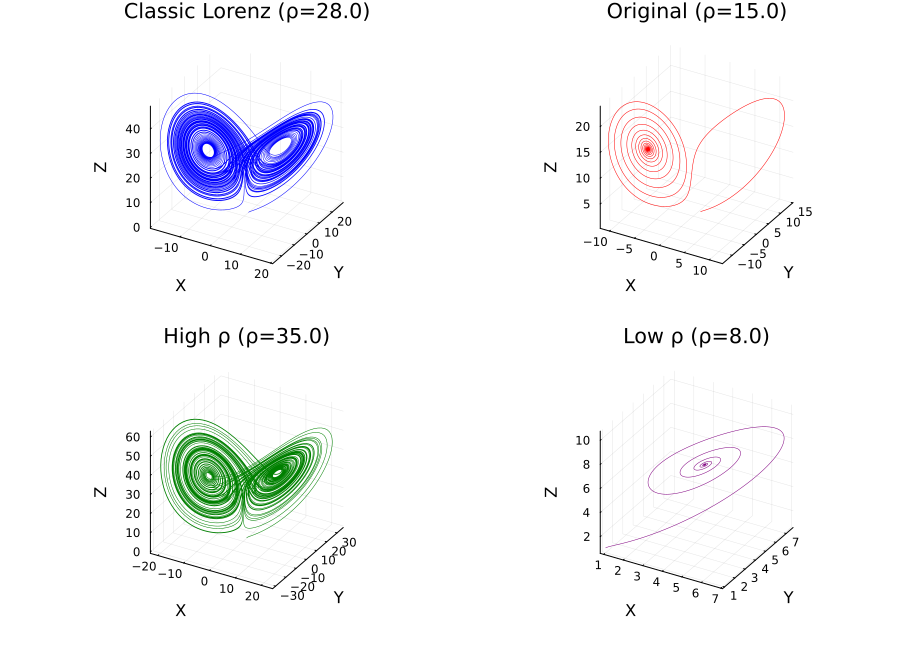

In [3]:
# 3D comparisons similar to the original script
kwargs3d = (; legend=false, linewidth=0.5, seriestype=:path3d)
p1 = plot(sol_classic.u[:, 1], sol_classic.u[:, 2], sol_classic.u[:, 3];
            title="Classic Lorenz (ρ=28.0)", xlabel="X", ylabel="Y", zlabel="Z",
            linecolor=:blue, kwargs3d...)
p2 = plot(sol_stable.u[:, 1], sol_stable.u[:, 2], sol_stable.u[:, 3];
            title="Original (ρ=15.0)", xlabel="X", ylabel="Y", zlabel="Z",
            linecolor=:red, kwargs3d...)
p3 = plot(sol_highρ.u[:, 1], sol_highρ.u[:, 2], sol_highρ.u[:, 3];
            title="High ρ (ρ=35.0)", xlabel="X", ylabel="Y", zlabel="Z",
            linecolor=:green, kwargs3d...)
p4 = plot(sol_lowρ.u[:, 1], sol_lowρ.u[:, 2], sol_lowρ.u[:, 3];
            title="Low ρ (ρ=8.0)", xlabel="X", ylabel="Y", zlabel="Z",
            linecolor=:purple, kwargs3d...)
plot(p1, p2, p3, p4, layout=(2,2), size=(900,650))

## Parameter Estimation with Classic Training

This section demonstrates parameter estimation using the classic `train!` function from the LorenzParameterEstimation package. The training process uses:

- **Target**: Classic Lorenz parameters (σ=10, ρ=28, β=8/3) with chaotic dynamics
- **Initial guess**: Poor starting values (σ=9, ρ=17, β=4) 
- **Training configuration**: 200 epochs with learning rate η=0.1
- **Window-based optimization**: 400-point trajectory segments for computational efficiency
- **All parameters updated**: σ, ρ, and β are all trainable

The `train!` function implements gradient descent with trajectory matching loss, computing gradients through the Lorenz integrator using automatic differentiation. This establishes the baseline performance before comparing different optimizer strategies in subsequent sections.

In [4]:
true_params = true_params_classic
x0_demo     = [1.0, 1.0, 1.0]
M_demo      = 10_000
T_demo      = 50.0
dt_demo     = T_demo / M_demo

true_sol_demo = integrate(true_params, x0_demo, (0.0, T_demo), dt_demo)

# Start from poor ρ and only update ρ
guess_params = L63Parameters(9.0, 17.0, 4)
cfg = L63TrainingConfig(
    epochs=200,
    η=1e-1,
    window_size=400,
    clip_norm=5.0,
    update_σ=true,
    update_ρ=true,
    update_β=true,
    verbose=true
)

best_params_demo, loss_hist_demo, param_hist_demo = train!(guess_params, true_sol_demo, cfg)



┌───────┬────────────┬────────────┬───────────┬───────────┬───────────┐
│ Epoch │   Train    │    Val     │      σ    │      ρ    │      β    │
├───────┼────────────┼────────────┼───────────┼───────────┼───────────┤
│     1 │  10.497817 │  11.224923 │    9.0020 │   17.1424 │    4.2235 │
│ Epoch │   Train    │    Val     │      σ    │      ρ    │      β    │
├───────┼────────────┼────────────┼───────────┼───────────┼───────────┤
│     1 │  10.497817 │  11.224923 │    9.0020 │   17.1424 │    4.2235 │
│     2 │   9.897711 │  11.200944 │    9.0101 │   17.2635 │    4.3575 │
│     3 │   8.841197 │  11.171357 │    9.0181 │   17.3972 │    4.4733 │
│     4 │  10.683330 │  11.147083 │    9.0251 │   17.4984 │    4.5368 │
│     5 │   9.284219 │  11.121780 │    9.0333 │   17.6296 │    4.6543 │
│     6 │   9.434296 │  11.095614 │    9.0445 │   17.7504 │    4.7224 │
│     7 │   9.105504 │  11.121556 │    9.0243 │   17.9977 │    5.2029 │
│     8 │   9.922261 │  11.100964 │    9.0293 │   18.0907 │    

(L63Parameters{Float64}(10.352327131828076, 27.983334985453812, 2.6543460401634147), @NamedTuple{train::Float64, validation::Union{Missing, Float64}}[@NamedTuple{train::Float64, validation::Union{Missing, Float64}}((10.49781737401295, 11.224923071701792)), @NamedTuple{train::Float64, validation::Union{Missing, Float64}}((9.897710629663843, 11.200944484780363)), @NamedTuple{train::Float64, validation::Union{Missing, Float64}}((8.841197491759782, 11.171356945073134)), @NamedTuple{train::Float64, validation::Union{Missing, Float64}}((10.683329776896217, 11.147082527480233)), @NamedTuple{train::Float64, validation::Union{Missing, Float64}}((9.284219215780105, 11.121780025979067)), @NamedTuple{train::Float64, validation::Union{Missing, Float64}}((9.434296106455843, 11.095613883765898)), @NamedTuple{train::Float64, validation::Union{Missing, Float64}}((9.105503606443108, 11.121555968729393)), @NamedTuple{train::Float64, validation::Union{Missing, Float64}}((9.922260913499734, 11.100963765210


================ Results ================
True    : σ=10.000000,  ρ=28.000000,  β=2.666667
Initial : σ=9.000000,  ρ=17.000000,  β=4.000000
Learned : σ=10.352327,  ρ=27.983335,  β=2.654346
Final epoch-average RMSE: 3.791099

================ Parameter Estimation Results ================
ρ Error: 13.000000 → 0.016665 (99.87% reduction)
Learned : σ=10.352327,  ρ=27.983335,  β=2.654346
Final epoch-average RMSE: 3.791099

================ Parameter Estimation Results ================
ρ Error: 13.000000 → 0.016665 (99.87% reduction)


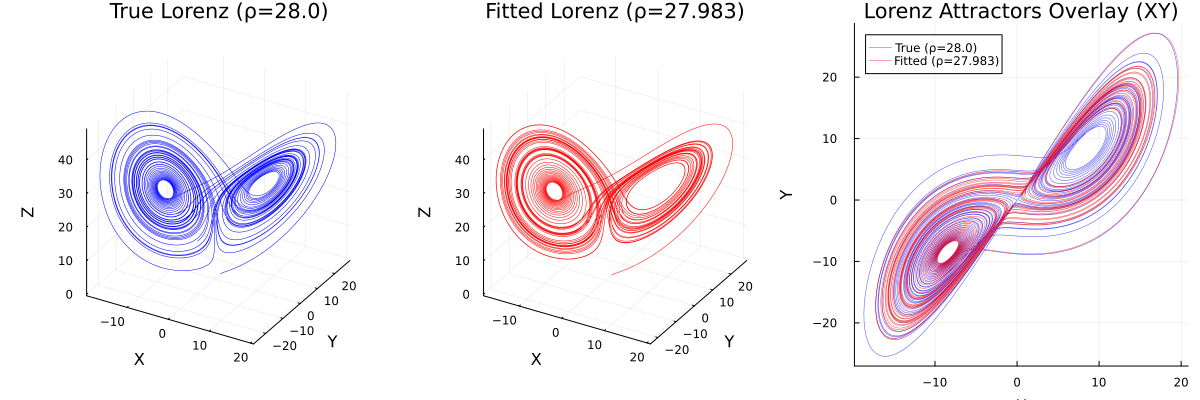

In [5]:
println("\n================ Results ================")
@printf("True    : σ=%.6f,  ρ=%.6f,  β=%.6f\n", true_params.σ, true_params.ρ, true_params.β)
@printf("Initial : σ=%.6f,  ρ=%.6f,  β=%.6f\n", guess_params.σ, guess_params.ρ, guess_params.β)
@printf("Learned : σ=%.6f,  ρ=%.6f,  β=%.6f\n", best_params_demo.σ, best_params_demo.ρ, best_params_demo.β)
# Fix: Access the .train field from the NamedTuple metrics
@printf("Final epoch-average RMSE: %.6f\n", last(loss_hist_demo).train)

println("\n================ Parameter Estimation Results ================")
@printf("ρ Error: %.6f → %.6f (%.2f%% reduction)\n",
        abs(15.0 - 28.0), abs(best_params_demo.ρ - 28.0),
        100 * (1 - abs(best_params_demo.ρ - 28.0) / abs(15.0 - 28.0)))

# Generate fitted trajectory for comparison
fitted_sol = integrate(best_params_demo, x0_demo, (0.0, T_demo), dt_demo)


# Component-wise comparison
p1 = plot(true_sol_demo.t, true_sol_demo.u[:,1], label="True (ρ=28.0)", linewidth=1, alpha=0.8)
plot!(p1, fitted_sol.t, fitted_sol.u[:,1], label="Fitted (ρ=$(round(best_params_demo.ρ, digits=3)))",
        linewidth=1, alpha=0.8, linestyle=:dash)
xlabel!(p1, "Time"); ylabel!(p1, "X"); title!(p1, "X Component")

p2 = plot(true_sol_demo.t, true_sol_demo.u[:,2], label="True (ρ=28.0)", linewidth=1, alpha=0.8)
plot!(p2, fitted_sol.t, fitted_sol.u[:,2], label="Fitted (ρ=$(round(best_params_demo.ρ, digits=3)))",
        linewidth=1, alpha=0.8, linestyle=:dash)
xlabel!(p2, "Time"); ylabel!(p2, "Y"); title!(p2, "Y Component")

p3 = plot(true_sol_demo.t, true_sol_demo.u[:,3], label="True (ρ=28.0)", linewidth=1, alpha=0.8)
plot!(p3, fitted_sol.t, fitted_sol.u[:,3], label="Fitted (ρ=$(round(best_params_demo.ρ, digits=3)))",
        linewidth=1, alpha=0.8, linestyle=:dash)
xlabel!(p3, "Time"); ylabel!(p3, "Z"); title!(p3, "Z Component")

# Loss convergence plot - Fix: Extract .train values for plotting
train_losses = [metric.train for metric in loss_hist_demo]
p4 = plot(1:length(train_losses), train_losses, linewidth=2, color=:red,
            xlabel="Epoch", ylabel="RMSE Loss", title="Training Loss Convergence",
            legend=false, yscale=:log10)

plot(p1, p2, p3, p4, layout=(2,2), size=(1000,700))

# 3D Lorenz attractor comparison
p_true = plot(true_sol_demo.u[:, 1], true_sol_demo.u[:, 2], true_sol_demo.u[:, 3];
                title="True Lorenz (ρ=28.0)", legend=false, linewidth=0.5,
                seriestype=:path3d, linecolor=:blue, xlabel="X", ylabel="Y", zlabel="Z")
p_fitted = plot(fitted_sol.u[:, 1], fitted_sol.u[:, 2], fitted_sol.u[:, 3];
                title="Fitted Lorenz (ρ=$(round(best_params_demo.ρ, digits=3)))",
                legend=false, linewidth=0.5, seriestype=:path3d,
                linecolor=:red, xlabel="X", ylabel="Y", zlabel="Z")

# Overlay comparison in XY plane for clarity
p_overlay = plot(true_sol_demo.u[:,1], true_sol_demo.u[:,2], label="True (ρ=28.0)",
                    linecolor=:blue, linewidth=0.5, alpha=0.7)
plot!(p_overlay, fitted_sol.u[:,1], fitted_sol.u[:,2], label="Fitted (ρ=$(round(best_params_demo.ρ, digits=3)))",
        linecolor=:red, linewidth=0.5, alpha=0.7)
title!(p_overlay, "Lorenz Attractors Overlay (XY)")
xlabel!(p_overlay, "X"); ylabel!(p_overlay, "Y")

plot(p_true, p_fitted, p_overlay, layout=(1,3), size=(1200,400))



In [6]:
println("\n================ Training Configuration ================")
println("Target Parameters: σ=$(true_params.σ), ρ=$(true_params.ρ), β=$(round(true_params.β, digits=3))")
println("Initial Guess: σ=$(guess_params.σ), ρ=$(guess_params.ρ), β=$(guess_params.β)")
println("Training Settings:")
println("   • Epochs: $(cfg.epochs)")
println("   • Learning Rate: $(cfg.η)")
println("   • Window Size: $(cfg.window_size) points")
println("   • Gradient Clipping: $(cfg.clip_norm)")
println("   • Parameters Updated: σ=$(cfg.update_mask.σ), ρ=$(cfg.update_mask.ρ), β=$(cfg.update_mask.β)")
println("   • Loss Function: Trajectory RMSE")
println("   • Stopping Condition: Fixed epochs (no early stopping)")
println("   • Time Window: T=$(T_demo), dt=$(dt_demo)")
println("   • Integration Method: Runge-Kutta 4th order")

# Optional animation (requires GR/FFMPEG via Plots and the visualization extension)
try
    gif_path = joinpath(@__DIR__, "lorenz_training_all_parameters_evolution.gif")
    gif_file = LorenzParameterEstimation.create_training_gif(
        true_params, param_hist_demo, train_losses, true_sol_demo;
        fps=3, filename=gif_path, stride=2)
    println("Training evolution GIF saved to: $(abspath(gif_file))")
catch e
    @warn "Training evolution animation failed (ensure GR/FFMPEG available)" error=e
end


================ Training Configuration ================
Target Parameters: σ=10.0, ρ=28.0, β=2.667
Initial Guess: σ=9.0, ρ=17.0, β=4.0
Training Settings:
   • Epochs: 200
   • Learning Rate: 0.1
   • Window Size: 400 points
   • Gradient Clipping: 5.0
   • Parameters Updated: σ=true, ρ=true, β=true
   • Loss Function: Trajectory RMSE
   • Stopping Condition: Fixed epochs (no early stopping)
   • Time Window: T=50.0, dt=0.005
   • Integration Method: Runge-Kutta 4th order


┌ Info: Saved animation to /Users/niklasviebig/master_thesis/LorenzParameterEstimation/examples/basic_training/lorenz_training_all_parameters_evolution.gif
└ @ Plots /Users/niklasviebig/.julia/packages/Plots/8ZnR3/src/animation.jl:156


Training evolution GIF saved to: /Users/niklasviebig/master_thesis/LorenzParameterEstimation/examples/basic_training/lorenz_training_all_parameters_evolution.gif


## Modular Optimizer Comparison

This section demonstrates the new modular training framework with different optimization algorithms. Unlike the previous classic training that used a fixed gradient descent approach, the modular system allows for flexible optimizer selection and configuration.

### Key Features of Modular Training:

- **Multiple Optimizers**: Adam, SGD, AdaGrad, and custom optimizer chains
- **Flexible Configuration**: Each optimizer can be configured with specific hyperparameters
- **Early Stopping**: Automatic convergence detection with patience and minimum delta thresholds
- **Comprehensive Tracking**: Parameter evolution and loss history for detailed analysis
- **Gradient Clipping**: Built-in support for gradient norm clipping in custom configurations

### Experimental Setup:

- **Target**: Classic Lorenz parameters (σ=10, ρ=28, β=8/3)
- **Initial guess**: σ=10, ρ=17, β=8/3 (only ρ parameter updated)
- **Training window**: 100-point trajectory segments
- **Maximum epochs**: 200 with early stopping
- **Focused optimization**: Only the Rayleigh parameter (ρ) is trainable

This approach provides a systematic comparison of optimization strategies for parameter estimation in chaotic dynamical systems, enabling identification of the most effective methods for Lorenz-63 parameter recovery.

In [7]:
# Test data
params_true = L63Parameters(10.0, 28.0, 8.0/3.0)
target_solution = integrate(params_true, [1.0, 1.0, 1.0], (0.0, 10.0), 0.01)
initial_guess = L63Parameters(10.0, 17.0, 8.0/3.0)

# 1. Adam Optimizer (default)
println("1️⃣ Training with Adam optimizer:")
result_adam = modular_train!(
    initial_guess, 
    target_solution,
    optimizer_config = adam_config(learning_rate=0.01),
    epochs = 200,
    window_size = 100,
    update_σ = false,
    update_ρ = true,
    update_β = false,
    verbose = true,
    early_stopping_patience = 25,
    early_stopping_min_delta = 1e-6

)
println("   Adam result: σ=$(round(result_adam.best_params.σ, digits=3)), ρ=$(round(result_adam.best_params.ρ, digits=3)), β=$(round(result_adam.best_params.β, digits=3))")

1️⃣ Training with Adam optimizer:
   Optimizer: Adam
   Data: 15 train windows, 4 val windows
   Window size: 100, stride: 50
   Updating: σ=false, ρ=true, β=false

Epoch │   Train    │    Val     │      σ     │      ρ     │      β     │
──────┼────────────┼────────────┼────────────┼────────────┼────────────┤
   Data: 15 train windows, 4 val windows
   Window size: 100, stride: 50
   Updating: σ=false, ρ=true, β=false

Epoch │   Train    │    Val     │      σ     │      ρ     │      β     │
──────┼────────────┼────────────┼────────────┼────────────┼────────────┤


ErrorException: type Float64 has no field avg_grads

In [8]:
# Plot results comparison for Adam optimizer
println("\n📊 Adam Training Results Visualization")

# Generate trajectories for comparison
initial_sol = integrate(
      initial_guess,          # Use the defined initial guess
      [1.0, 1.0, 1.0],        # Initial condition
      (0.0, 10.0),            # Time span
      0.01)                   # Time step
      
final_sol = integrate(result_adam.best_params, [1.0, 1.0, 1.0], (0.0, 10.0), 0.01)
true_sol = integrate(params_true, [1.0, 1.0, 1.0], (0.0, 10.0), 0.01)

# Parameter comparison bar plot
param_names = ["σ", "ρ", "β"]
initial_vals = [initial_guess.σ, initial_guess.ρ, initial_guess.β]
final_vals = [result_adam.best_params.σ, result_adam.best_params.ρ, result_adam.best_params.β]
true_vals = [params_true.σ, params_true.ρ, params_true.β]

p_params = groupedbar([initial_vals final_vals true_vals], 
                      bar_position = :dodge,
                      labels = ["Initial" "Adam Final" "True"],
                      title = "Adam: Parameter Comparison",
                      xlabel = "Parameters", ylabel = "Value",
                      xticks = (1:3, param_names),
                      colors = [:red :blue :green])

# 3D trajectory comparison
p_traj = plot(true_sol.u[:, 1], true_sol.u[:, 2], true_sol.u[:, 3],
              label="True (σ=$(params_true.σ), ρ=$(params_true.ρ), β=$(round(params_true.β, digits=2)))",
              linecolor=:green, linewidth=1, alpha=0.8, seriestype=:path3d)
plot!(p_traj, initial_sol.u[:, 1], initial_sol.u[:, 2], initial_sol.u[:, 3],
      label="Initial (σ=$(initial_guess.σ), ρ=$(initial_guess.ρ), β=$(initial_guess.β))",
      linecolor=:red, linewidth=1, alpha=0.7, seriestype=:path3d)
plot!(p_traj, final_sol.u[:, 1], final_sol.u[:, 2], final_sol.u[:, 3],
      label="Adam Final (σ=$(round(result_adam.best_params.σ, digits=2)), ρ=$(round(result_adam.best_params.ρ, digits=2)), β=$(round(result_adam.best_params.β, digits=2)))",
      linecolor=:blue, linewidth=1, alpha=0.8, seriestype=:path3d)
title!(p_traj, "Adam: Lorenz Attractor Trajectories")
xlabel!(p_traj, "X"); ylabel!(p_traj, "Y"); zlabel!(p_traj, "Z")

# Time series comparison (X component)
p_time = plot(true_sol.t, true_sol.u[:, 1], label="True", linecolor=:green, linewidth=1.5)
plot!(p_time, initial_sol.t, initial_sol.u[:, 1], label="Initial", linecolor=:red, linewidth=1, alpha=0.7)
plot!(p_time, final_sol.t, final_sol.u[:, 1], label="Adam Final", linecolor=:blue, linewidth=1, linestyle=:dash)
title!(p_time, "Adam: X Component Time Series")
xlabel!(p_time, "Time"); ylabel!(p_time, "X")

plot(p_params, p_traj, p_time, layout=(1,3), size=(1200,400))


📊 Adam Training Results Visualization


UndefVarError: UndefVarError: `result_adam` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

## 2. SGD Optimizer

In [9]:
# 2. Stochastic Gradient Descent
println("2️⃣ Training with SGD:")
result_sgd = modular_train!(
    initial_guess, target_solution,
    optimizer_config = sgd_config(learning_rate=0.005),
    epochs = 200,
    window_size = 100,
    update_σ = false,
    update_ρ = true,
    update_β = false,
    verbose = true,
    early_stopping_patience = 20,
    early_stopping_min_delta = 1e-6

)
println("   SGD result: σ=$(round(result_sgd.best_params.σ, digits=3)), ρ=$(round(result_sgd.best_params.ρ, digits=3)), β=$(round(result_sgd.best_params.β, digits=3))")

2️⃣ Training with SGD:
   Optimizer: SGD
   Data: 15 train windows, 4 val windows
   Window size: 100, stride: 50
   Updating: σ=false, ρ=true, β=false

Epoch │   Train    │    Val     │      σ     │      ρ     │      β     │
──────┼────────────┼────────────┼────────────┼────────────┼────────────┤
   Data: 15 train windows, 4 val windows
   Window size: 100, stride: 50
   Updating: σ=false, ρ=true, β=false

Epoch │   Train    │    Val     │      σ     │      ρ     │      β     │
──────┼────────────┼────────────┼────────────┼────────────┼────────────┤


ErrorException: type Float64 has no field avg_grads

In [10]:
# Plot results comparison for SGD optimizer
println("\n📊 SGD Training Results Visualization")

# Generate trajectory for SGD result
sgd_sol = integrate(result_sgd.best_params, [1.0, 1.0, 1.0], (0.0, 10.0), 0.01)

# Parameter comparison bar plot
sgd_vals = [result_sgd.best_params.σ, result_sgd.best_params.ρ, result_sgd.best_params.β]

p_params_sgd = groupedbar([initial_vals sgd_vals true_vals], 
                          bar_position = :dodge,
                          labels = ["Initial" "SGD Final" "True"],
                          title = "SGD: Parameter Comparison",
                          xlabel = "Parameters", ylabel = "Value",
                          xticks = (1:3, param_names),
                          colors = [:red :orange :green])

# 3D trajectory comparison
p_traj_sgd = plot(true_sol.u[:, 1], true_sol.u[:, 2], true_sol.u[:, 3],
                  label="True", linecolor=:green, linewidth=1, alpha=0.8, seriestype=:path3d)
plot!(p_traj_sgd, initial_sol.u[:, 1], initial_sol.u[:, 2], initial_sol.u[:, 3],
      label="Initial", linecolor=:red, linewidth=1, alpha=0.7, seriestype=:path3d)
plot!(p_traj_sgd, sgd_sol.u[:, 1], sgd_sol.u[:, 2], sgd_sol.u[:, 3],
      label="SGD Final (σ=$(round(result_sgd.best_params.σ, digits=2)), ρ=$(round(result_sgd.best_params.ρ, digits=2)), β=$(round(result_sgd.best_params.β, digits=2)))",
      linecolor=:orange, linewidth=1, alpha=0.8, seriestype=:path3d)
title!(p_traj_sgd, "SGD: Lorenz Attractor Trajectories")
xlabel!(p_traj_sgd, "X"); ylabel!(p_traj_sgd, "Y"); zlabel!(p_traj_sgd, "Z")

# Time series comparison (X component)
p_time_sgd = plot(true_sol.t, true_sol.u[:, 1], label="True", linecolor=:green, linewidth=1.5)
plot!(p_time_sgd, initial_sol.t, initial_sol.u[:, 1], label="Initial", linecolor=:red, linewidth=1, alpha=0.7)
plot!(p_time_sgd, sgd_sol.t, sgd_sol.u[:, 1], label="SGD Final", linecolor=:orange, linewidth=1, linestyle=:dash)
title!(p_time_sgd, "SGD: X Component Time Series")
xlabel!(p_time_sgd, "Time"); ylabel!(p_time_sgd, "X")

plot(p_params_sgd, p_traj_sgd, p_time_sgd, layout=(1,3), size=(1200,400))


📊 SGD Training Results Visualization


UndefVarError: UndefVarError: `result_sgd` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

## 3.AdaGrad Optimizer

In [11]:
# 3. AdaGrad Optimizer
println("3️⃣ Training with AdaGrad:")
result_adagrad = modular_train!(
    initial_guess, target_solution,
    optimizer_config = adagrad_config(learning_rate=0.1),
    epochs = 200,
    window_size = 100,
    update_σ = false,
    update_ρ = true,
    update_β = false,
    verbose = true,
    early_stopping_patience = 15,
    early_stopping_min_delta = 1e-6

)
println("   AdaGrad result: σ=$(round(result_adagrad.best_params.σ, digits=3)), ρ=$(round(result_adagrad.best_params.ρ, digits=3)), β=$(round(result_adagrad.best_params.β, digits=3))")

3️⃣ Training with AdaGrad:
   Optimizer: Adagrad
   Data: 15 train windows, 4 val windows
   Window size: 100, stride: 50
   Updating: σ=false, ρ=true, β=false

Epoch │   Train    │    Val     │      σ     │      ρ     │      β     │
──────┼────────────┼────────────┼────────────┼────────────┼────────────┤


ErrorException: type Float64 has no field avg_grads

In [12]:
# Plot results comparison for AdaGrad optimizer
println("\n📊 AdaGrad Training Results Visualization")

# Generate trajectory for AdaGrad result
adagrad_sol = integrate(result_adagrad.best_params, [1.0, 1.0, 1.0], (0.0, 10.0), 0.01)

# Parameter comparison bar plot
adagrad_vals = [result_adagrad.best_params.σ, result_adagrad.best_params.ρ, result_adagrad.best_params.β]

p_params_ada = groupedbar([initial_vals adagrad_vals true_vals], 
                          bar_position = :dodge,
                          labels = ["Initial" "AdaGrad Final" "True"],
                          title = "AdaGrad: Parameter Comparison",
                          xlabel = "Parameters", ylabel = "Value",
                          xticks = (1:3, param_names),
                          colors = [:red :purple :green])

# 3D trajectory comparison
p_traj_ada = plot(true_sol.u[:, 1], true_sol.u[:, 2], true_sol.u[:, 3],
                  label="True", linecolor=:green, linewidth=1, alpha=0.8, seriestype=:path3d)
plot!(p_traj_ada, initial_sol.u[:, 1], initial_sol.u[:, 2], initial_sol.u[:, 3],
      label="Initial", linecolor=:red, linewidth=1, alpha=0.7, seriestype=:path3d)
plot!(p_traj_ada, adagrad_sol.u[:, 1], adagrad_sol.u[:, 2], adagrad_sol.u[:, 3],
      label="AdaGrad Final (σ=$(round(result_adagrad.best_params.σ, digits=2)), ρ=$(round(result_adagrad.best_params.ρ, digits=2)), β=$(round(result_adagrad.best_params.β, digits=2)))",
      linecolor=:purple, linewidth=1, alpha=0.8, seriestype=:path3d)
title!(p_traj_ada, "AdaGrad: Lorenz Attractor Trajectories")
xlabel!(p_traj_ada, "X"); ylabel!(p_traj_ada, "Y"); zlabel!(p_traj_ada, "Z")

# Time series comparison (X component)
p_time_ada = plot(true_sol.t, true_sol.u[:, 1], label="True", linecolor=:green, linewidth=1.5)
plot!(p_time_ada, initial_sol.t, initial_sol.u[:, 1], label="Initial", linecolor=:red, linewidth=1, alpha=0.7)
plot!(p_time_ada, adagrad_sol.t, adagrad_sol.u[:, 1], label="AdaGrad Final", linecolor=:purple, linewidth=1, linestyle=:dash)
title!(p_time_ada, "AdaGrad: X Component Time Series")
xlabel!(p_time_ada, "Time"); ylabel!(p_time_ada, "X")

plot(p_params_ada, p_traj_ada, p_time_ada, layout=(1,3), size=(1200,400))


📊 AdaGrad Training Results Visualization


UndefVarError: UndefVarError: `result_adagrad` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

# 4. Custom optimizer Configuration

In [13]:
# 4. Custom Optimizer Configuration
println("4️⃣ Training with custom optimizer (Adam + gradient clipping):")
using Optimisers

custom_optimizer = Optimisers.OptimiserChain(
    Optimisers.ClipNorm(1.0),      # Gradient clipping
    Optimisers.Adam(0.01, (0.9, 0.99))  # Adam with custom β values
)

# Fix: Use positional arguments for OptimizerConfig constructor
custom_config = OptimizerConfig(
    custom_optimizer,
    0.01,  # learning_rate (positional argument)
    name = "Custom Adam + ClipNorm"
)

result_custom = modular_train!(
    initial_guess, target_solution,
    optimizer_config = custom_config,
    epochs = 200,
    window_size = 100,
    update_σ = false,
    update_ρ = true,
    update_β = false,
    verbose = true,
    early_stopping_patience = 20,
    early_stopping_min_delta = 1e-6
)


println("   Custom result: σ=$(round(result_custom.best_params.σ, digits=3)), ρ=$(round(result_custom.best_params.ρ, digits=3)), β=$(round(result_custom.best_params.β, digits=3))")

4️⃣ Training with custom optimizer (Adam + gradient clipping):
   Optimizer: Custom Adam + ClipNorm
   Data: 15 train windows, 4 val windows
   Window size: 100, stride: 50
   Updating: σ=false, ρ=true, β=false

Epoch │   Train    │    Val     │      σ     │      ρ     │      β     │
──────┼────────────┼────────────┼────────────┼────────────┼────────────┤


ErrorException: type Float64 has no field avg_grads

In [14]:
# Plot results comparison for Custom optimizer
println("\n📊 Custom Optimizer Training Results Visualization")

# Generate trajectory for Custom optimizer result
custom_sol = integrate(result_custom.best_params, [1.0, 1.0, 1.0], (0.0, 10.0), 0.01)

# Parameter comparison bar plot
custom_vals = [result_custom.best_params.σ, result_custom.best_params.ρ, result_custom.best_params.β]

p_params_custom = groupedbar([initial_vals custom_vals true_vals], 
                             bar_position = :dodge,
                             labels = ["Initial" "Custom Final" "True"],
                             title = "Custom (Adam+ClipNorm): Parameter Comparison",
                             xlabel = "Parameters", ylabel = "Value",
                             xticks = (1:3, param_names),
                             colors = [:red :cyan :green])

# 3D trajectory comparison
p_traj_custom = plot(true_sol.u[:, 1], true_sol.u[:, 2], true_sol.u[:, 3],
                     label="True", linecolor=:green, linewidth=1, alpha=0.8, seriestype=:path3d)
plot!(p_traj_custom, initial_sol.u[:, 1], initial_sol.u[:, 2], initial_sol.u[:, 3],
      label="Initial", linecolor=:red, linewidth=1, alpha=0.7, seriestype=:path3d)
plot!(p_traj_custom, custom_sol.u[:, 1], custom_sol.u[:, 2], custom_sol.u[:, 3],
      label="Custom Final (σ=$(round(result_custom.best_params.σ, digits=2)), ρ=$(round(result_custom.best_params.ρ, digits=2)), β=$(round(result_custom.best_params.β, digits=2)))",
      linecolor=:cyan, linewidth=1, alpha=0.8, seriestype=:path3d)
title!(p_traj_custom, "Custom: Lorenz Attractor Trajectories")
xlabel!(p_traj_custom, "X"); ylabel!(p_traj_custom, "Y"); zlabel!(p_traj_custom, "Z")

# Time series comparison (X component)
p_time_custom = plot(true_sol.t, true_sol.u[:, 1], label="True", linecolor=:green, linewidth=1.5)
plot!(p_time_custom, initial_sol.t, initial_sol.u[:, 1], label="Initial", linecolor=:red, linewidth=1, alpha=0.7)
plot!(p_time_custom, custom_sol.t, custom_sol.u[:, 1], label="Custom Final", linecolor=:cyan, linewidth=1, linestyle=:dash)
title!(p_time_custom, "Custom: X Component Time Series")
xlabel!(p_time_custom, "Time"); ylabel!(p_time_custom, "X")

plot(p_params_custom, p_traj_custom, p_time_custom, layout=(1,3), size=(1200,400))


📊 Custom Optimizer Training Results Visualization


UndefVarError: UndefVarError: `result_custom` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

## Optimizer comparison

In [15]:
# ========== COMPREHENSIVE OPTIMIZER COMPARISON ==========
println("\n🏆 Comprehensive Optimizer Comparison Summary")

# Define parameter value arrays (ensure all are defined)
adam_vals = [result_adam.best_params.σ, result_adam.best_params.ρ, result_adam.best_params.β]
sgd_vals = [result_sgd.best_params.σ, result_sgd.best_params.ρ, result_sgd.best_params.β]
adagrad_vals = [result_adagrad.best_params.σ, result_adagrad.best_params.ρ, result_adagrad.best_params.β]
custom_vals = [result_custom.best_params.σ, result_custom.best_params.ρ, result_custom.best_params.β]

# Calculate parameter errors for each optimizer
adam_error = sqrt((result_adam.best_params.σ - params_true.σ)^2 + 
                  (result_adam.best_params.ρ - params_true.ρ)^2 + 
                  (result_adam.best_params.β - params_true.β)^2)

sgd_error = sqrt((result_sgd.best_params.σ - params_true.σ)^2 + 
                 (result_sgd.best_params.ρ - params_true.ρ)^2 + 
                 (result_sgd.best_params.β - params_true.β)^2)

adagrad_error = sqrt((result_adagrad.best_params.σ - params_true.σ)^2 + 
                     (result_adagrad.best_params.ρ - params_true.ρ)^2 + 
                     (result_adagrad.best_params.β - params_true.β)^2)

custom_error = sqrt((result_custom.best_params.σ - params_true.σ)^2 + 
                    (result_custom.best_params.ρ - params_true.ρ)^2 + 
                    (result_custom.best_params.β - params_true.β)^2)

initial_error = sqrt((initial_guess.σ - params_true.σ)^2 + 
                     (initial_guess.ρ - params_true.ρ)^2 + 
                     (initial_guess.β - params_true.β)^2)

# All optimizer results for comparison
all_results = [initial_vals adam_vals sgd_vals adagrad_vals custom_vals true_vals]
optimizer_names = ["Initial", "Adam", "SGD", "AdaGrad", "Custom", "True"]
colors_all = [:red :blue :orange :purple :cyan :green]

# Parameter comparison across all optimizers with proper labels
p_all_params = groupedbar(all_results, 
                          bar_position = :dodge,
                          labels = permutedims(optimizer_names),
                          title = "Final Parameter Values: All Optimizers",
                          xlabel = "Lorenz-63 Parameters", ylabel = "Parameter Value",
                          xticks = (1:3, ["σ (Prandtl)", "ρ (Rayleigh)", "β (Geometry)"]),
                          colors = permutedims(colors_all))

# Error comparison bar chart with proper labels
errors = [initial_error, adam_error, sgd_error, adagrad_error, custom_error]
error_names = ["Initial\nGuess", "Adam", "SGD", "AdaGrad", "Custom\n(Adam+Clip)"]
p_errors = bar(error_names, errors, 
               title = "Total Parameter Error from True Values",
               ylabel = "L2 Error Distance", xlabel = "Optimization Method",
               color = [:red :blue :orange :purple :cyan],
               legend = false,
               rotation = 45)

# Performance summary table
println("\n📈 Optimizer Performance Summary:")
println("┌───────────┬───────┬───────┬───────┬──────────┬─────────┐")
println("│ Optimizer │   σ   │   ρ   │   β   │  Error   │ Epochs  │")
println("├───────────┼───────┼───────┼───────┼──────────┼─────────┤")
@printf("│ Initial   │ %5.2f │ %5.2f │ %5.2f │ %8.4f │   -     │\n", initial_guess.σ, initial_guess.ρ, initial_guess.β, initial_error)
@printf("│ Adam      │ %5.2f │ %5.2f │ %5.2f │ %8.4f │ %7d │\n", result_adam.best_params.σ, result_adam.best_params.ρ, result_adam.best_params.β, adam_error, length(result_adam.metrics_history))
@printf("│ SGD       │ %5.2f │ %5.2f │ %5.2f │ %8.4f │ %7d │\n", result_sgd.best_params.σ, result_sgd.best_params.ρ, result_sgd.best_params.β, sgd_error, length(result_sgd.metrics_history))
@printf("│ AdaGrad   │ %5.2f │ %5.2f │ %5.2f │ %8.4f │ %7d │\n", result_adagrad.best_params.σ, result_adagrad.best_params.ρ, result_adagrad.best_params.β, adagrad_error, length(result_adagrad.metrics_history))
@printf("│ Custom    │ %5.2f │ %5.2f │ %5.2f │ %8.4f │ %7d │\n", result_custom.best_params.σ, result_custom.best_params.ρ, result_custom.best_params.β, custom_error, length(result_custom.metrics_history))
@printf("│ True      │ %5.2f │ %5.2f │ %5.2f │ %8.4f │   -     │\n", params_true.σ, params_true.ρ, params_true.β, 0.0)
println("└───────────┴───────┴───────┴───────┴──────────┴─────────┘")

# Find best optimizer
best_idx = argmin([adam_error, sgd_error, adagrad_error, custom_error])
best_names = ["Adam", "SGD", "AdaGrad", "Custom"]
println("\n🎯 Best performer: $(best_names[best_idx]) with error $(round(minimum([adam_error, sgd_error, adagrad_error, custom_error]), digits=6))")

# Performance efficiency analysis
println("\n⚡ Efficiency Analysis:")
efficiencies = [error / epochs for (error, epochs) in zip([adam_error, sgd_error, adagrad_error, custom_error], 
                                                          [length(result_adam.metrics_history), length(result_sgd.metrics_history), 
                                                           length(result_adagrad.metrics_history), length(result_custom.metrics_history)])]
best_eff_idx = argmin(efficiencies)
println("• Most efficient (error/epoch): $(best_names[best_eff_idx]) with $(round(efficiencies[best_eff_idx], digits=8)) error per epoch")

plot(p_all_params, p_errors, layout=(1,2), size=(1200,600),
     plot_title="Lorenz-63 Parameter Estimation: Final Results Comparison",
     plot_titlefontsize=14)


🏆 Comprehensive Optimizer Comparison Summary


UndefVarError: UndefVarError: `result_adam` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [16]:
# ========== PARAMETER CONVERGENCE AND LOSS COMPARISON ==========
println("\n📊 Parameter Convergence and Loss Analysis")

# Extract loss histories for all optimizers (correct field: train_loss)
adam_losses = [metric.train_loss for metric in result_adam.metrics_history]
sgd_losses = [metric.train_loss for metric in result_sgd.metrics_history]
adagrad_losses = [metric.train_loss for metric in result_adagrad.metrics_history]
custom_losses = [metric.train_loss for metric in result_custom.metrics_history]

# Loss convergence comparison with proper axis labels
p_loss = plot(1:length(adam_losses), adam_losses, 
              label="Adam ($(length(adam_losses)) epochs)", linecolor=:blue, linewidth=2, yscale=:log10)
plot!(p_loss, 1:length(sgd_losses), sgd_losses, 
      label="SGD ($(length(sgd_losses)) epochs)", linecolor=:orange, linewidth=2)
plot!(p_loss, 1:length(adagrad_losses), adagrad_losses, 
      label="AdaGrad ($(length(adagrad_losses)) epochs)", linecolor=:purple, linewidth=2)
plot!(p_loss, 1:length(custom_losses), custom_losses, 
      label="Custom ($(length(custom_losses)) epochs)", linecolor=:cyan, linewidth=2)
title!(p_loss, "Training Loss Convergence")
xlabel!(p_loss, "Training Epoch")
ylabel!(p_loss, "RMSE Loss (log scale)")

# Parameter convergence for ρ (the parameter being optimized)
adam_rho_hist = [params.ρ for params in result_adam.param_history]
sgd_rho_hist = [params.ρ for params in result_sgd.param_history]
adagrad_rho_hist = [params.ρ for params in result_adagrad.param_history]
custom_rho_hist = [params.ρ for params in result_custom.param_history]

p_rho = plot(1:length(adam_rho_hist), adam_rho_hist, 
             label="Adam", linecolor=:blue, linewidth=2)
plot!(p_rho, 1:length(sgd_rho_hist), sgd_rho_hist, 
      label="SGD", linecolor=:orange, linewidth=2)
plot!(p_rho, 1:length(adagrad_rho_hist), adagrad_rho_hist, 
      label="AdaGrad", linecolor=:purple, linewidth=2)
plot!(p_rho, 1:length(custom_rho_hist), custom_rho_hist, 
      label="Custom", linecolor=:cyan, linewidth=2)
hline!(p_rho, [params_true.ρ], label="True ρ = $(params_true.ρ)", linecolor=:green, 
       linewidth=3, linestyle=:dash)
title!(p_rho, "ρ Parameter Convergence")
xlabel!(p_rho, "Training Epoch")
ylabel!(p_rho, "ρ Parameter Value")

# Combined parameter error over time
adam_error_hist = [sqrt((p.σ - params_true.σ)^2 + (p.ρ - params_true.ρ)^2 + (p.β - params_true.β)^2) 
                   for p in result_adam.param_history]
sgd_error_hist = [sqrt((p.σ - params_true.σ)^2 + (p.ρ - params_true.ρ)^2 + (p.β - params_true.β)^2) 
                  for p in result_sgd.param_history]
adagrad_error_hist = [sqrt((p.σ - params_true.σ)^2 + (p.ρ - params_true.ρ)^2 + (p.β - params_true.β)^2) 
                      for p in result_adagrad.param_history]
custom_error_hist = [sqrt((p.σ - params_true.σ)^2 + (p.ρ - params_true.ρ)^2 + (p.β - params_true.β)^2) 
                     for p in result_custom.param_history]

p_param_error = plot(1:length(adam_error_hist), adam_error_hist, 
                     label="Adam", linecolor=:blue, linewidth=2, yscale=:log10)
plot!(p_param_error, 1:length(sgd_error_hist), sgd_error_hist, 
      label="SGD", linecolor=:orange, linewidth=2)
plot!(p_param_error, 1:length(adagrad_error_hist), adagrad_error_hist, 
      label="AdaGrad", linecolor=:purple, linewidth=2)
plot!(p_param_error, 1:length(custom_error_hist), custom_error_hist, 
      label="Custom", linecolor=:cyan, linewidth=2)
title!(p_param_error, "Parameter Error Convergence")
xlabel!(p_param_error, "Training Epoch")
ylabel!(p_param_error, "L2 Parameter Error (log scale)")

# Create comprehensive analysis
println("\n🔍 Convergence Analysis (with Auto-stopping):")
println("• Adam: $(length(adam_losses)) epochs, final loss = $(round(adam_losses[end], digits=4))")
println("• SGD: $(length(sgd_losses)) epochs, final loss = $(round(sgd_losses[end], digits=4))")  
println("• AdaGrad: $(length(adagrad_losses)) epochs, final loss = $(round(adagrad_losses[end], digits=4))")
println("• Custom: $(length(custom_losses)) epochs, final loss = $(round(custom_losses[end], digits=4))")

# Check if any optimizer stopped early
max_epochs = 200
early_stops = []
if length(adam_losses) < max_epochs
    push!(early_stops, "Adam (stopped at epoch $(length(adam_losses)))")
end
if length(sgd_losses) < max_epochs
    push!(early_stops, "SGD (stopped at epoch $(length(sgd_losses)))")
end
if length(adagrad_losses) < max_epochs
    push!(early_stops, "AdaGrad (stopped at epoch $(length(adagrad_losses)))")
end
if length(custom_losses) < max_epochs
    push!(early_stops, "Custom (stopped at epoch $(length(custom_losses)))")
end

if !isempty(early_stops)
    println("\n⏹️  Early stopping triggered for: $(join(early_stops, ", "))")
else
    println("\n📈 All optimizers ran to completion ($(max_epochs) epochs)")
end

plot(p_loss, p_rho, p_param_error, layout=(1,3), size=(1400,500),
     plot_title="Lorenz-63 Parameter Estimation: Optimizer Convergence Analysis",
     plot_titlefontsize=14)


📊 Parameter Convergence and Loss Analysis


UndefVarError: UndefVarError: `result_adam` not defined in `Main`
Suggestion: check for spelling errors or missing imports.